# 网络中的网络（NiN）

前几节介绍的LeNet、AlexNet和VGG在设计上的共同之处是：先以由卷积层构成的模块充分抽取空间特征，再以由全连接层构成的模块来输出分类结果。其中，AlexNet和VGG对LeNet的改进主要在于如何对这两个模块加宽（增加通道数）和加深。本节我们介绍网络中的网络（NiN）[1]。它提出了另外一个思路，即串联多个由卷积层和“全连接”层构成的小网络来构建一个深层网络。


## NiN块

我们知道，卷积层的输入和输出通常是四维数组（样本，通道，高，宽），而全连接层的输入和输出则通常是二维数组（样本，特征）。如果想在全连接层后再接上卷积层，则需要将全连接层的输出变换为四维。回忆在[“多输入通道和多输出通道”](channels.ipynb)一节里介绍的$1\times 1$卷积层。它可以看成全连接层，其中空间维度（高和宽）上的每个元素相当于样本，通道相当于特征。因此，NiN使用$1\times 1$卷积层来替代全连接层，从而使空间信息能够自然传递到后面的层中去。图5.7对比了NiN同AlexNet和VGG等网络在结构上的主要区别。

![左图是AlexNet和VGG的网络结构局部，右图是NiN的网络结构局部](../img/nin.svg)

NiN块是NiN中的基础块。它由一个卷积层加两个充当全连接层的$1\times 1$卷积层串联而成。其中第一个卷积层的超参数可以自行设置，而第二和第三个卷积层的超参数一般是固定的。

In [1]:
import tensorflow as tf
print(tf.__version__)

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2.16.1


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

def nin_block(num_channels, kernel_size, strides, padding):
    """
    创建一个网络中的网络(NiN)块。

    参数:
    num_channels (int): 卷积层的输出通道数
    kernel_size (int 或 tuple): 卷积核的大小
    strides (int 或 tuple): 卷积步长
    padding (str): 填充方式，'valid' 或 'same'

    返回:
    tf.keras.models.Sequential: NiN块的顺序模型
    """
    # 创建一个顺序模型作为NiN块
    blk = Sequential()
    
    # 添加第一个卷积层，可自定义参数
    blk.add(Conv2D(num_channels, kernel_size,
                   strides=strides, padding=padding, 
                   activation='relu'))
    
    # 添加第二个1x1卷积层，相当于全连接层
    blk.add(Conv2D(num_channels, kernel_size=1, 
                   activation='relu')) 
    
    # 添加第三个1x1卷积层，相当于全连接层
    blk.add(Conv2D(num_channels, kernel_size=1, 
                   activation='relu'))    
    
    return blk

## NiN模型

NiN是在AlexNet问世不久后提出的。它们的卷积层设定有类似之处。NiN使用卷积窗口形状分别为$11\times 11$、$5\times 5$和$3\times 3$的卷积层，相应的输出通道数也与AlexNet中的一致。每个NiN块后接一个步幅为2、窗口形状为$3\times 3$的最大池化层。

除使用NiN块以外，NiN还有一个设计与AlexNet显著不同：NiN去掉了AlexNet最后的3个全连接层，取而代之地，NiN使用了输出通道数等于标签类别数的NiN块，然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。这里的全局平均池化层即窗口形状等于输入空间维形状的平均池化层。NiN的这个设计的好处是可以显著减小模型参数尺寸，从而缓解过拟合。然而，该设计有时会造成获得有效模型的训练时间的增加。

In [3]:
from tensorflow.keras.layers import MaxPool2D, Dropout, GlobalAveragePooling2D, Flatten

net = Sequential()
# 第一个NiN块，96个输出通道，11x11卷积核，步长4
net.add(nin_block(96, kernel_size=11, strides=4, padding='valid'))
# 最大池化层，3x3窗口，步长2
net.add(MaxPool2D(pool_size=3, strides=2))
# 第二个NiN块，256个输出通道，5x5卷积核，步长1
net.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
# 最大池化层，3x3窗口，步长2
net.add(MaxPool2D(pool_size=3, strides=2))
# 第三个NiN块，384个输出通道，3x3卷积核，步长1
net.add(nin_block(384, kernel_size=3, strides=1, padding='same'))
# 最大池化层，3x3窗口，步长2
net.add(MaxPool2D(pool_size=3, strides=2))
# Dropout层，防止过拟合
net.add(Dropout(0.5))
# 最后一个NiN块，10个输出通道（对应10个类别），3x3卷积核，步长1
net.add(nin_block(10, kernel_size=3, strides=1, padding='same'))
# 全局平均池化层，将每个通道的特征图平均成一个值
net.add(GlobalAveragePooling2D())
# 展平层，将结果转换为一维向量
net.add(Flatten())

下面构造一个高和宽均为224的单通道数据样本来观察每一层的输出形状。

In [4]:
X = tf.random.uniform((1,224,224,1))
for blk in net.layers:
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

sequential_1 output shape:	 (1, 54, 54, 96)
max_pooling2d output shape:	 (1, 26, 26, 96)
sequential_2 output shape:	 (1, 26, 26, 256)
max_pooling2d_1 output shape:	 (1, 12, 12, 256)
sequential_3 output shape:	 (1, 12, 12, 384)
max_pooling2d_2 output shape:	 (1, 5, 5, 384)
dropout output shape:	 (1, 5, 5, 384)
sequential_4 output shape:	 (1, 5, 5, 10)
global_average_pooling2d output shape:	 (1, 10)
flatten output shape:	 (1, 10)


## 获取数据和训练模型

我们依然使用Fashion-MNIST数据集来训练模型。NiN的训练与AlexNet和VGG的类似，但这里使用的学习率更大。

In [5]:
import numpy as np

class DataLoader():
    def __init__(self):
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = fashion_mnist.load_data()
        self.train_images = np.expand_dims(self.train_images.astype(np.float32)/255.0,axis=-1)
        self.test_images = np.expand_dims(self.test_images.astype(np.float32)/255.0,axis=-1)
        self.train_labels = self.train_labels.astype(np.int32)
        self.test_labels = self.test_labels.astype(np.int32)
        self.num_train, self.num_test = self.train_images.shape[0], self.test_images.shape[0]
        
    def get_batch_train(self, batch_size):
        index = np.random.randint(0, np.shape(self.train_images)[0], batch_size)
        #need to resize images to (224,224)
        resized_images = tf.image.resize_with_pad(self.train_images[index],224,224,)
        return resized_images.numpy(), self.train_labels[index]
    
    def get_batch_test(self, batch_size):
        index = np.random.randint(0, np.shape(self.test_images)[0], batch_size)
        #need to resize images to (224,224)
        resized_images = tf.image.resize_with_pad(self.test_images[index],224,224,)
        return resized_images.numpy(), self.test_labels[index]

batch_size = 128
dataLoader = DataLoader()
x_batch, y_batch = dataLoader.get_batch_train(batch_size)
print("x_batch shape:",x_batch.shape,"y_batch shape:", y_batch.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_batch shape: (128, 224, 224, 1) y_batch shape: (128,)


In [6]:
def train_nin():
    import os
    
    weights_file_path = "5.8_nin.weights.h5"
    if os.path.exists(weights_file_path):
        net.load_weights(weights_file_path)
    else:
        print(f"权重文件 {weights_file_path} 未找到，跳过加载权重")
    epoch = 5
    num_iter = dataLoader.num_train//batch_size
    for e in range(epoch):
        for n in range(num_iter):
            x_batch, y_batch = dataLoader.get_batch_train(batch_size)
            net.fit(x_batch, y_batch)
            if n%20 == 0:
                net.save_weights("5.8_nin.weights.h5")
                
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.06, momentum=0.3, nesterov=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
net.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

x_batch, y_batch = dataLoader.get_batch_train(batch_size)
net.fit(x_batch, y_batch)
train_nin()

I0000 00:00:1729579933.299589      65 service.cc:145] XLA service 0x788dc8047b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729579933.299652      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1063 - loss: 3.4475


I0000 00:00:1729579939.188579      65 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1729579939.196340      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


权重文件 5.8_nin.weights.h5 未找到，跳过加载权重
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0521 - loss: 3.7751
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0812 - loss: 3.7612
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0906 - loss: 3.3021
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0854 - loss: 3.6667
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0885 - loss: 3.3413
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1615 - loss: 3.3845
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0646 - loss: 3.8597
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1281 - loss: 3.4924
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1146 - loss: 3.4515
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0906 - loss: 3.6198
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0594 - loss: 3.6236
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0677 - loss: 3.5575
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0740 - loss: 3.5100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2

我们将训练好的参数读入，然后取测试数据计算测试准确率

In [7]:
# net.load_weights("5.8_nin.weights.h5")

x_test, y_test = dataLoader.get_batch_test(2000)
net.evaluate(x_test, y_test, verbose=2)

63/63 - 2s - 28ms/step - accuracy: 0.1390 - loss: 2.6493


[2.649256944656372, 0.13899999856948853]

## 可视化展示模型最后一层的特征值

第一层卷积核形状: (11, 11, 1, 96)


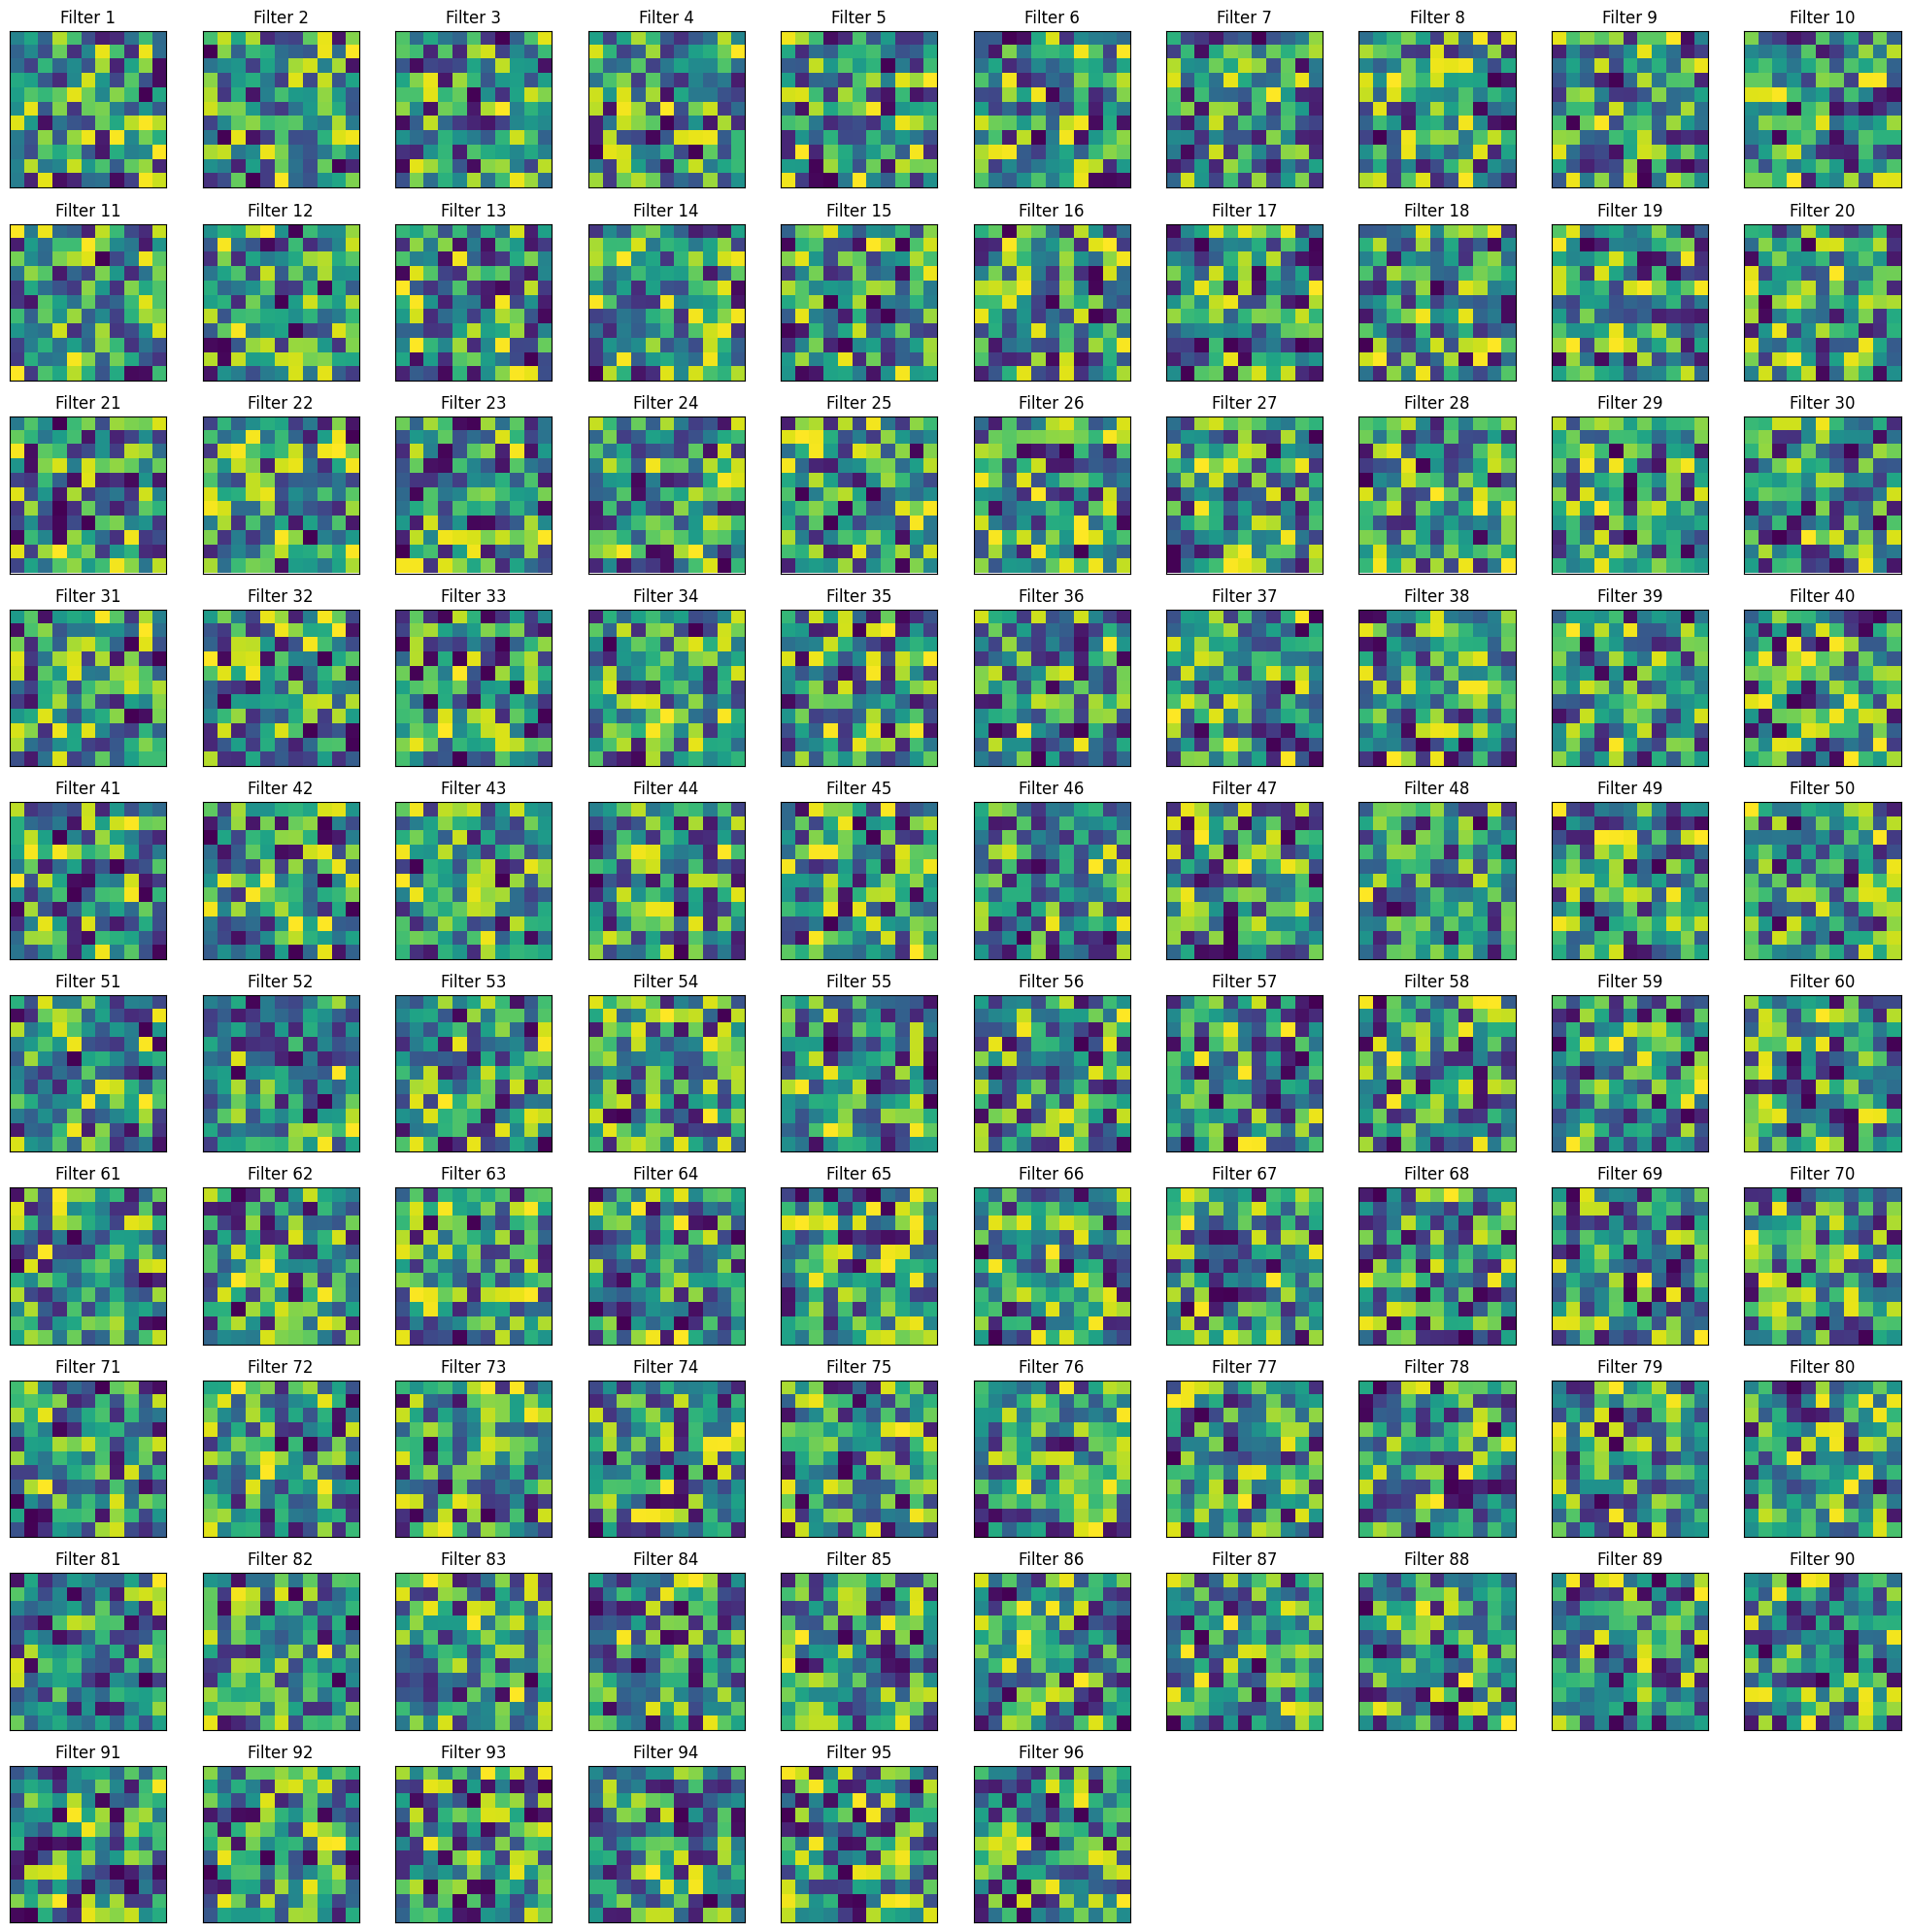


原始权重:
  最小值: -0.022716017
  最大值: 0.022721719
  平均值: 2.1740438e-05
  标准差: 0.013070866

标准化后的权重:
  最小值: -1.7395754
  最大值: 1.736685
  平均值: -1.37928104e-08
  标准差: 0.9999999


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 获取第一个 NiN 块的权重
first_nin_block = net.layers[0]
first_conv_layer = first_nin_block.layers[0]  # 获取 NiN 块中的第一个卷积层
first_layer_weights = first_conv_layer.get_weights()[0]

# 获取权重的形状
weight_shape = first_layer_weights.shape
print("第一层卷积核形状:", weight_shape)

# 创建一个函数来可视化权重
def visualize_first_layer(weights):
    # 假设权重形状为 (11, 11, 1, 96)，如果不是，可能需要调整
    n_filters = weights.shape[3]
    n_rows = int(np.ceil(np.sqrt(n_filters)))
    n_cols = int(np.ceil(n_filters / n_rows))
    
    plt.figure(figsize=(20, 20))
    for i in range(n_filters):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        
        # 获取单个滤波器的权重
        w = weights[:, :, 0, i]
        
        # 标准化权重
        w_normalized = stats.zscore(w.flatten()).reshape(w.shape)
        
        plt.imshow(w_normalized, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Filter {i+1}')
    
    plt.tight_layout()
    plt.show()

# 可视化第一层卷积核
visualize_first_layer(first_layer_weights)

# 打印权重的统计信息
print("\n原始权重:")
print("  最小值:", np.min(first_layer_weights))
print("  最大值:", np.max(first_layer_weights))
print("  平均值:", np.mean(first_layer_weights))
print("  标准差:", np.std(first_layer_weights))

# 计算标准化后的权重统计信息
normalized_weights = stats.zscore(first_layer_weights.flatten()).reshape(first_layer_weights.shape)
print("\n标准化后的权重:")
print("  最小值:", np.min(normalized_weights))
print("  最大值:", np.max(normalized_weights))
print("  平均值:", np.mean(normalized_weights))
print("  标准差:", np.std(normalized_weights))

第二层卷积核形状: (5, 5, 96, 256)


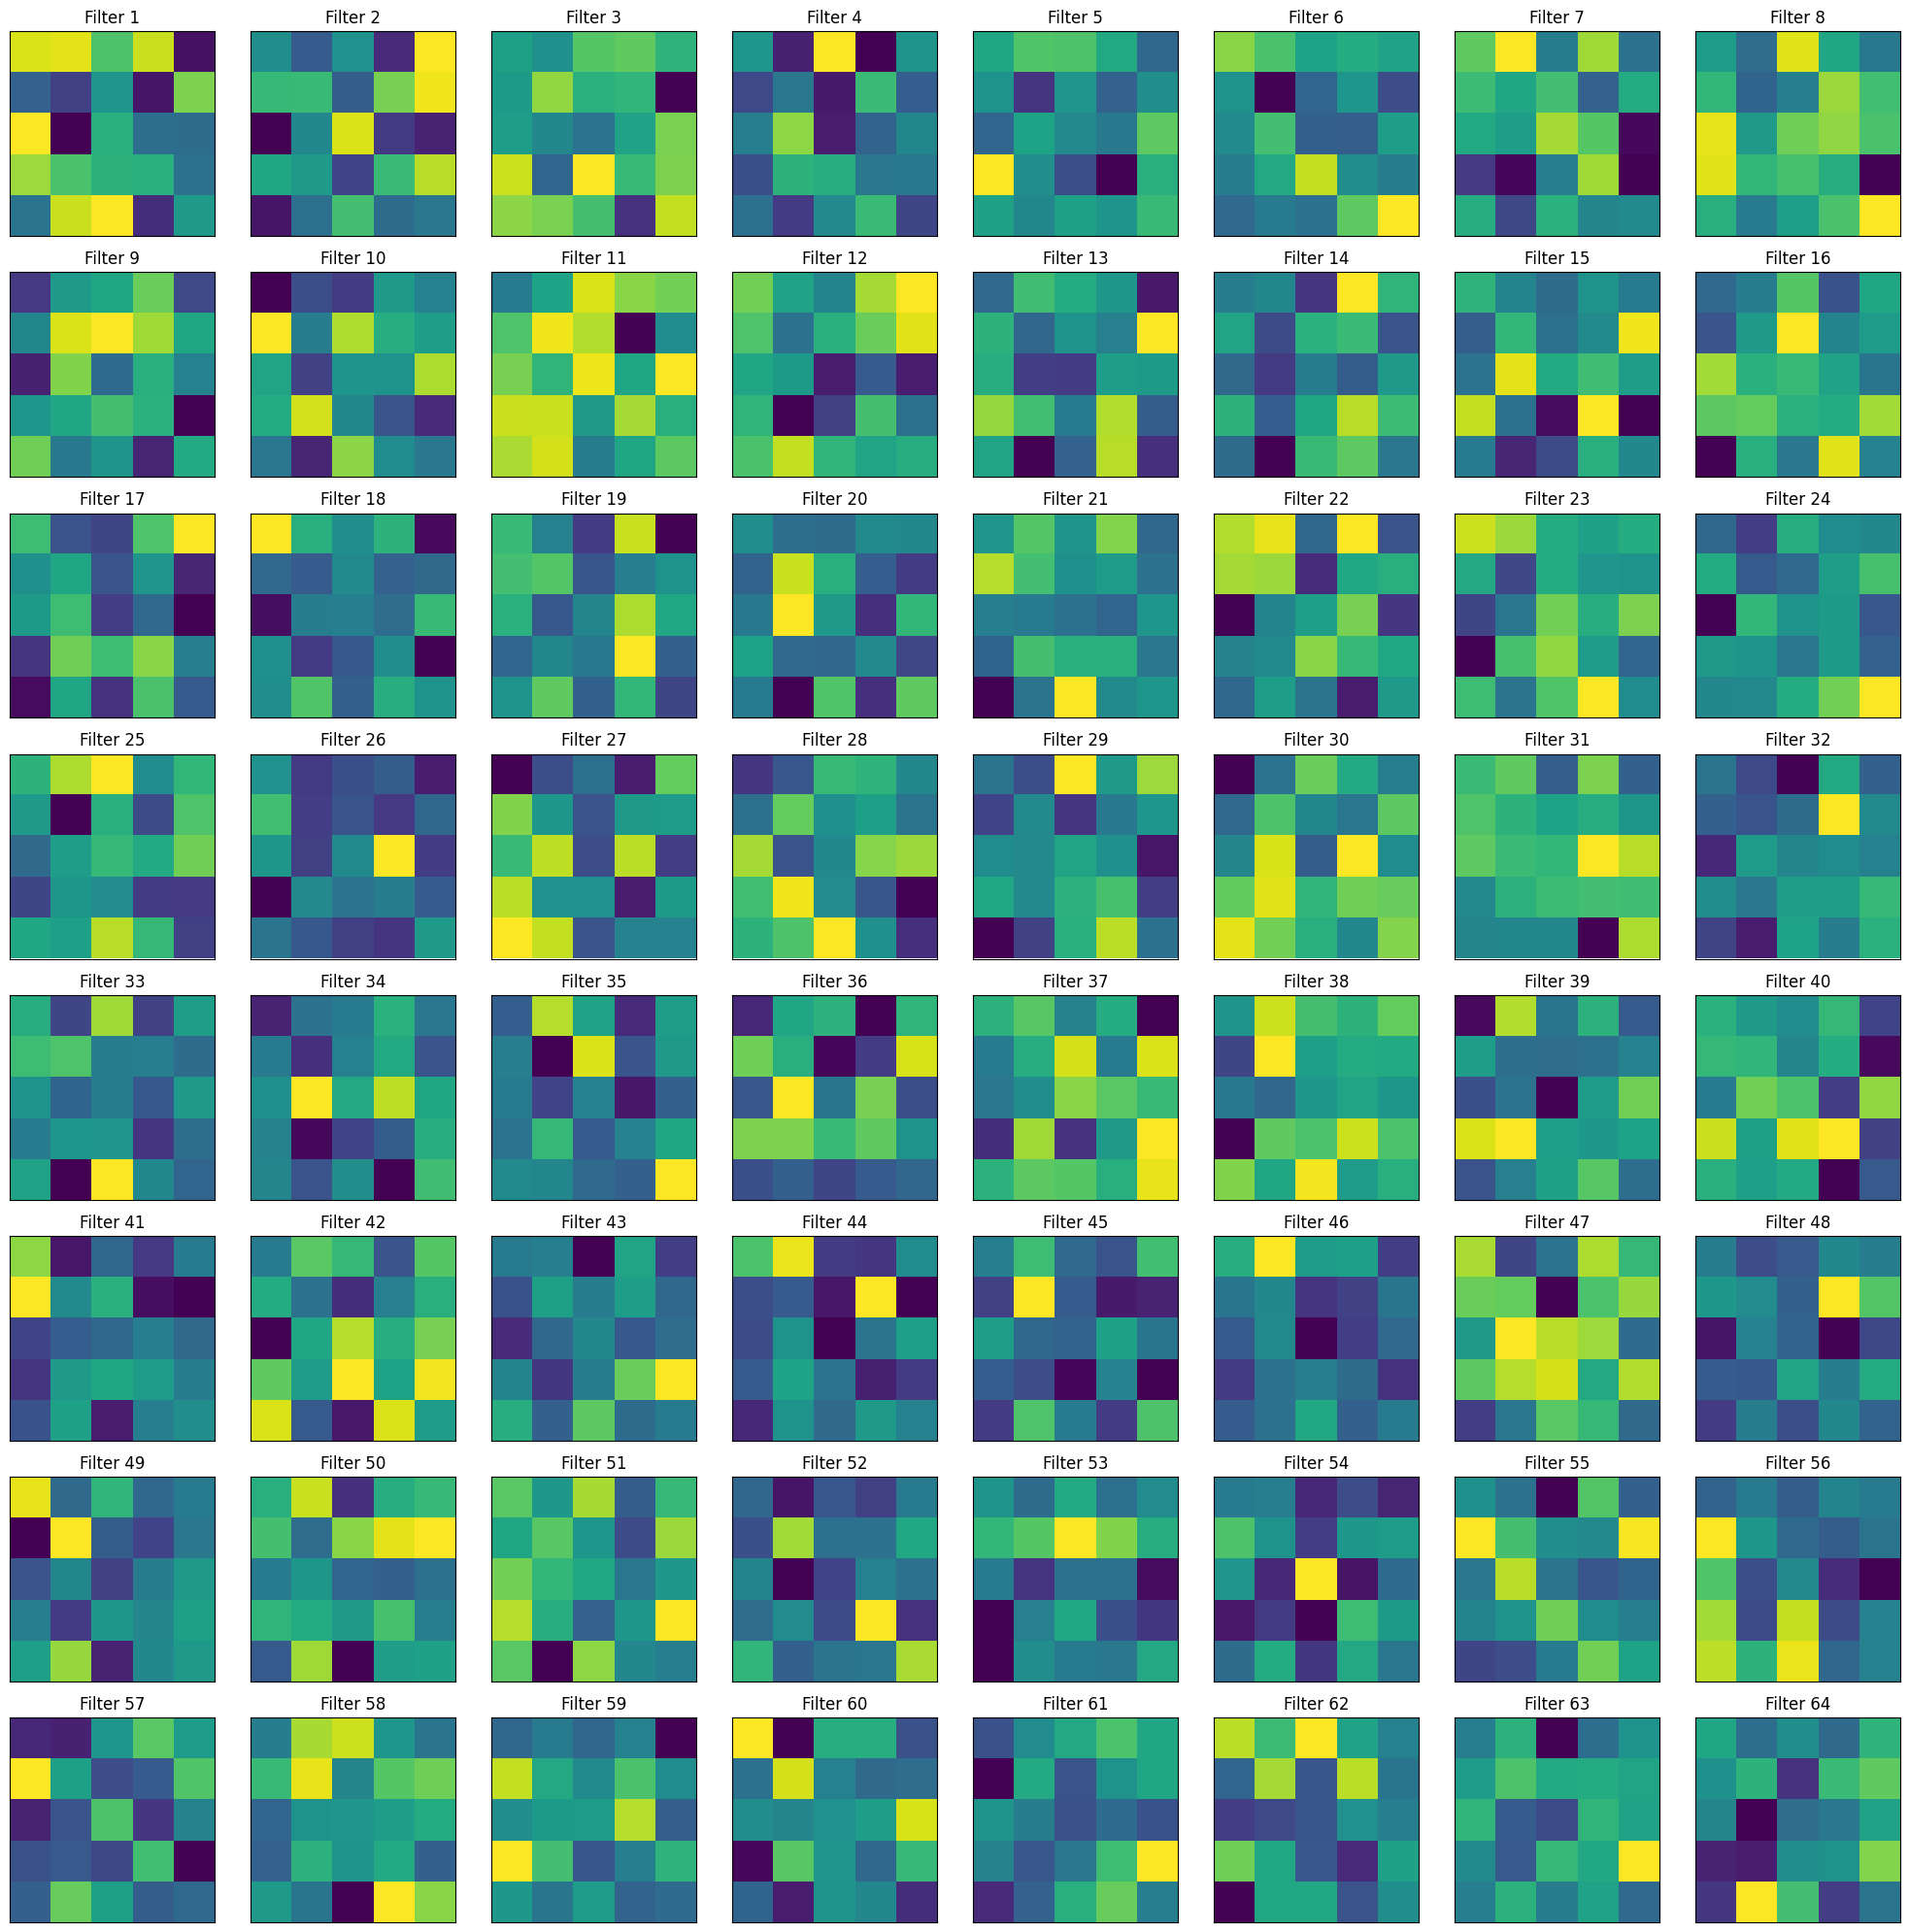


原始权重:
  最小值: -0.026501343
  最大值: 0.026571007
  平均值: -4.622652e-06
  标准差: 0.015070532

标准化后的权重:
  最小值: -1.7581807
  最大值: 1.7634169
  平均值: 1.9961346e-08
  标准差: 0.99999994


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 获取第二个 NiN 块的权重
second_nin_block = net.layers[2]  # 假设第二个 NiN 块是网络的第三层（索引为2）
second_conv_layer = second_nin_block.layers[0]  # 获取 NiN 块中的第一个卷积层
second_layer_weights = second_conv_layer.get_weights()[0]

# 获取权重的形状
weight_shape = second_layer_weights.shape
print("第二层卷积核形状:", weight_shape)

# 创建一个函数来可视化权重
def visualize_second_layer(weights, num_filters_to_show=64):
    n_filters = min(weights.shape[3], num_filters_to_show)
    n_channels = weights.shape[2]
    n_rows = int(np.ceil(np.sqrt(n_filters)))
    n_cols = int(np.ceil(n_filters / n_rows))
    
    plt.figure(figsize=(20, 20))
    for i in range(n_filters):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        
        # 对所有输入通道的权重取平均
        w = np.mean(weights[:, :, :, i], axis=2)
        
        # 标准化权重
        w_normalized = stats.zscore(w.flatten()).reshape(w.shape)
        
        plt.imshow(w_normalized, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Filter {i+1}')
    
    plt.tight_layout()
    plt.show()

# 可视化第二层卷积核
visualize_second_layer(second_layer_weights)

# 打印权重的统计信息
print("\n原始权重:")
print("  最小值:", np.min(second_layer_weights))
print("  最大值:", np.max(second_layer_weights))
print("  平均值:", np.mean(second_layer_weights))
print("  标准差:", np.std(second_layer_weights))

# 计算标准化后的权重统计信息
normalized_weights = stats.zscore(second_layer_weights.flatten()).reshape(second_layer_weights.shape)
print("\n标准化后的权重:")
print("  最小值:", np.min(normalized_weights))
print("  最大值:", np.max(normalized_weights))
print("  平均值:", np.mean(normalized_weights))
print("  标准差:", np.std(normalized_weights))

第三层卷积核形状: (3, 3, 256, 384)


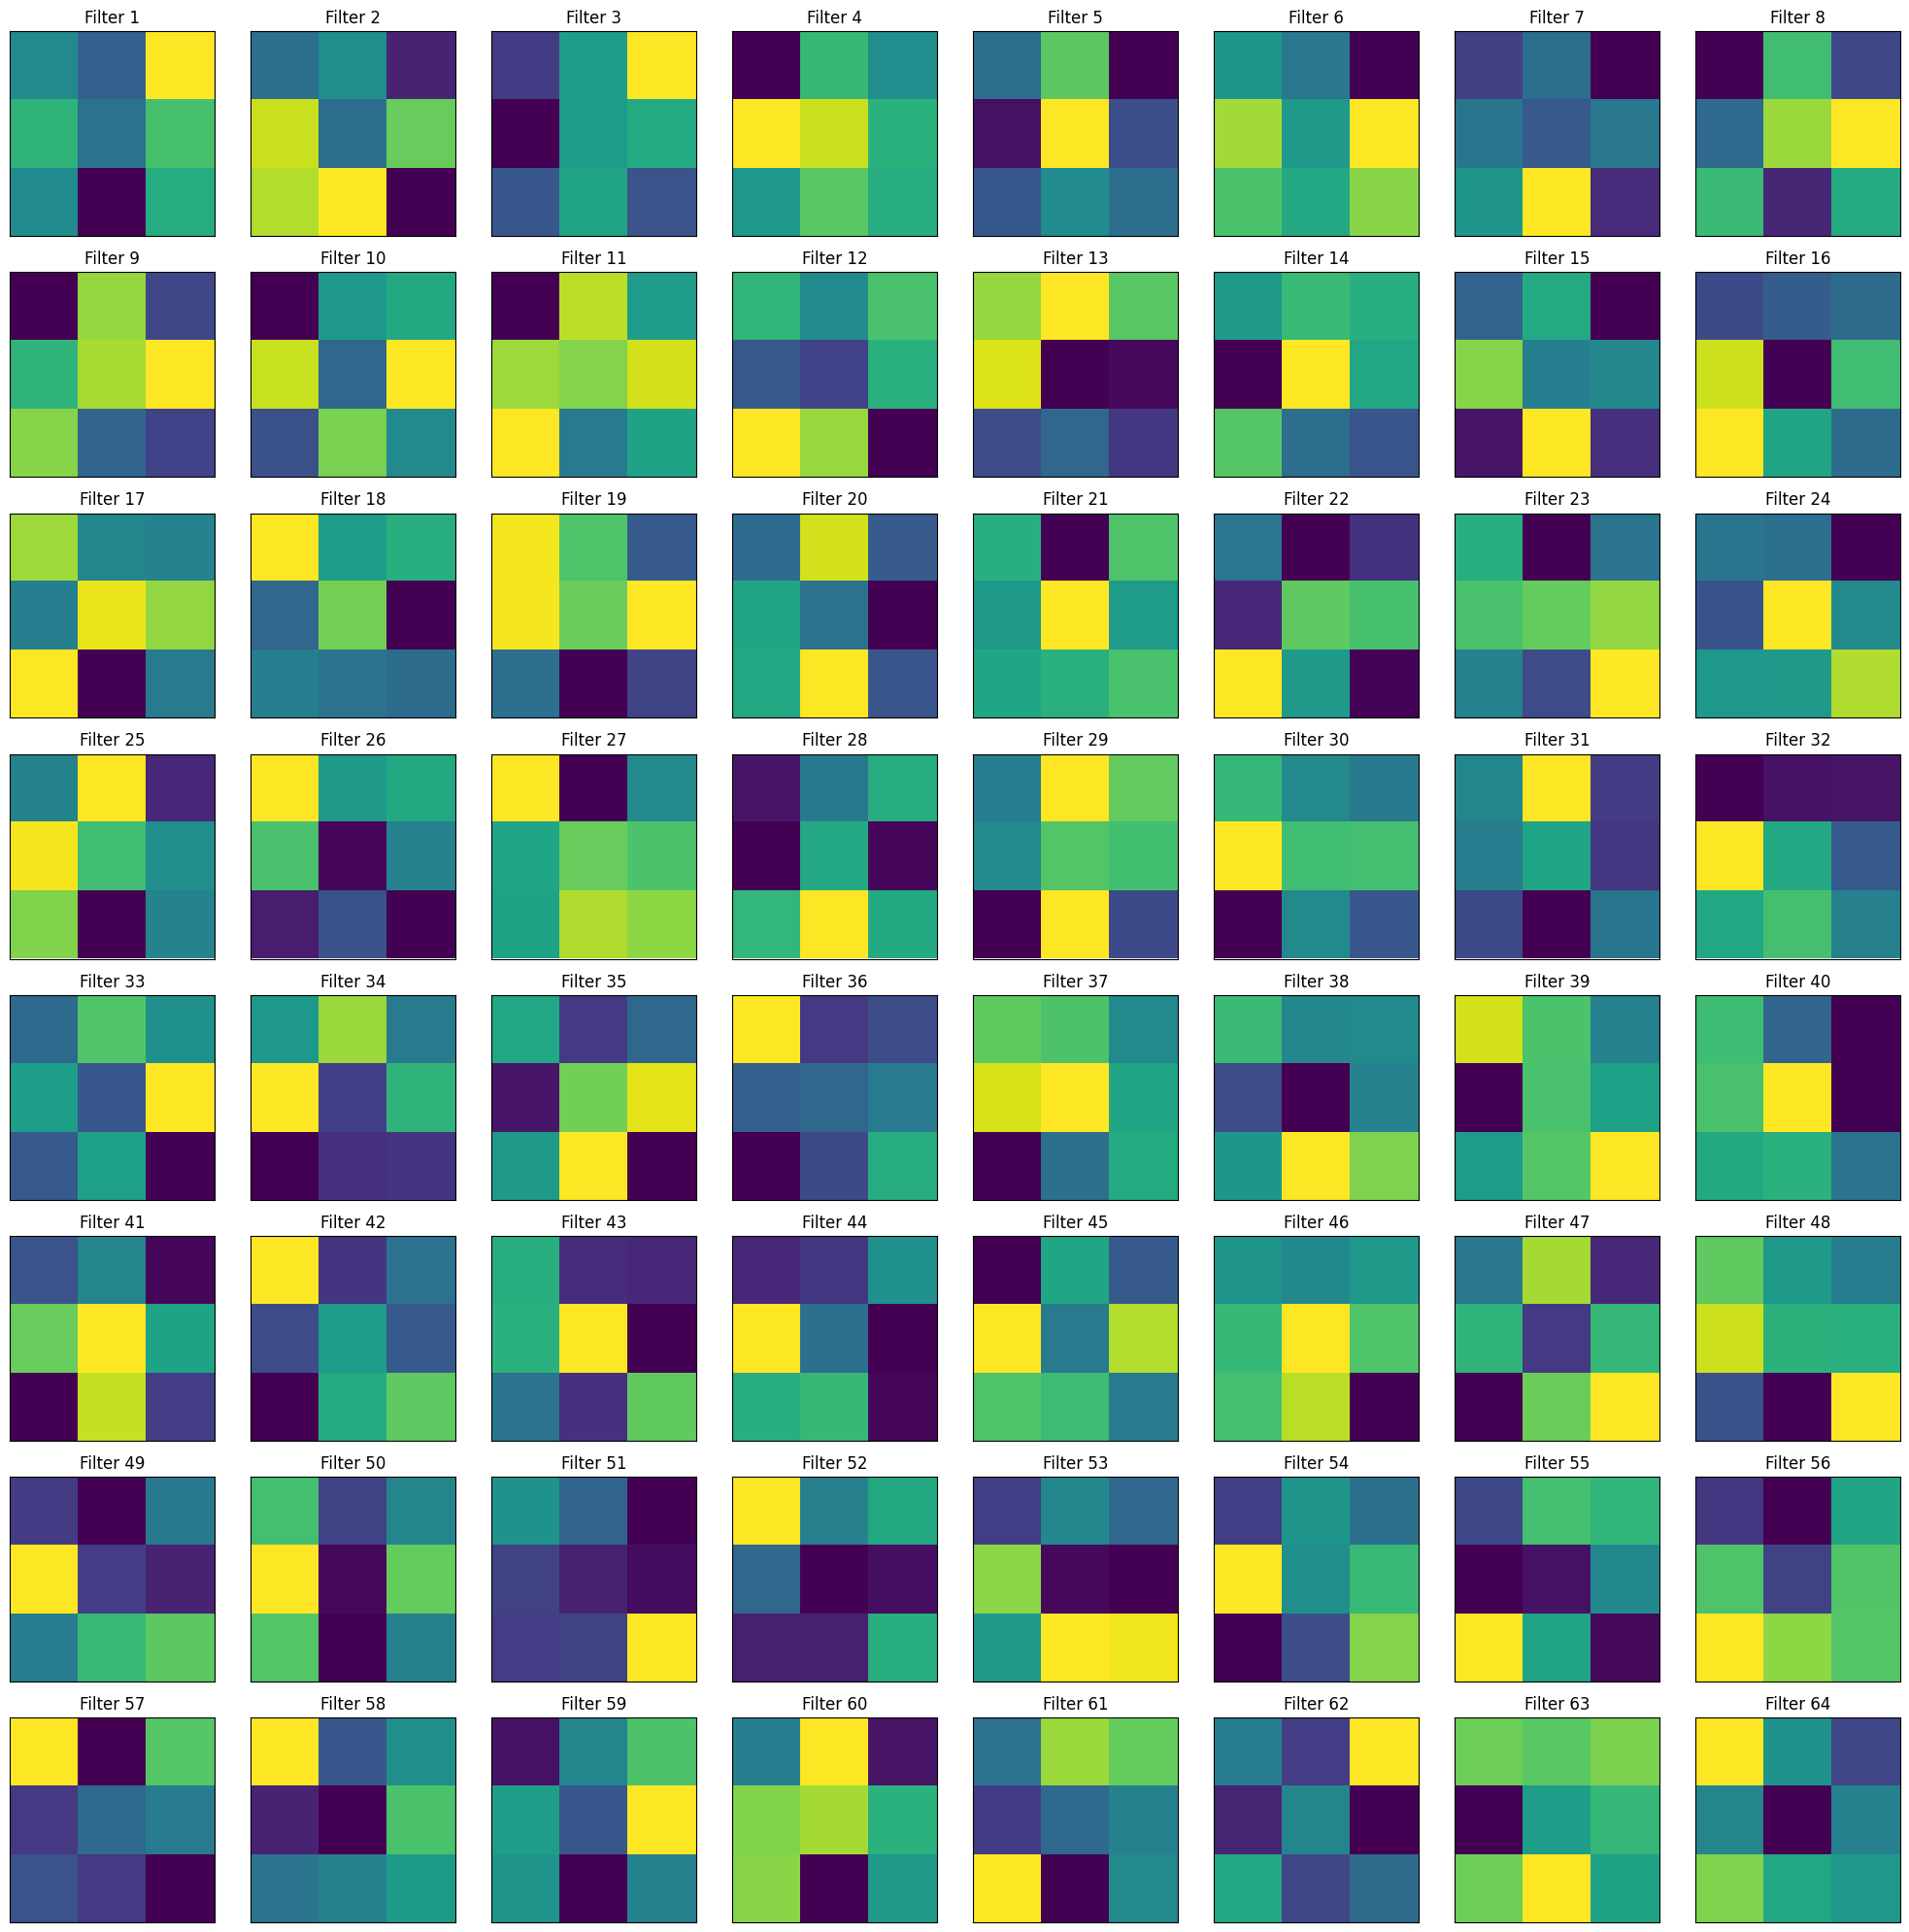


原始权重:
  最小值: -0.032815747
  最大值: 0.032701053
  平均值: -2.4032884e-06
  标准差: 0.018630225

标准化后的权重:
  最小值: -1.7612962
  最大值: 1.7553978
  平均值: -6.9418027e-09
  标准差: 1.0


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 获取第三个 NiN 块的权重
third_nin_block = net.layers[4]  # 假设第三个 NiN 块是网络的第五层（索引为4）
third_conv_layer = third_nin_block.layers[0]  # 获取 NiN 块中的第一个卷积层
third_layer_weights = third_conv_layer.get_weights()[0]

# 获取权重的形状
weight_shape = third_layer_weights.shape
print("第三层卷积核形状:", weight_shape)

# 创建一个函数来可视化权重
def visualize_third_layer(weights, num_filters_to_show=64):
    n_filters = min(weights.shape[3], num_filters_to_show)
    n_rows = int(np.ceil(np.sqrt(n_filters)))
    n_cols = int(np.ceil(n_filters / n_rows))
    
    plt.figure(figsize=(20, 20))
    for i in range(n_filters):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        
        # 对所有输入通道的权重取平均
        w = np.mean(weights[:, :, :, i], axis=2)
        
        # 标准化权重
        w_normalized = stats.zscore(w.flatten()).reshape(w.shape)
        
        plt.imshow(w_normalized, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Filter {i+1}')
    
    plt.tight_layout()
    plt.show()

# 可视化第三层卷积核
visualize_third_layer(third_layer_weights)

# 打印权重的统计信息
print("\n原始权重:")
print("  最小值:", np.min(third_layer_weights))
print("  最大值:", np.max(third_layer_weights))
print("  平均值:", np.mean(third_layer_weights))
print("  标准差:", np.std(third_layer_weights))

# 计算标准化后的权重统计信息
normalized_weights = stats.zscore(third_layer_weights.flatten()).reshape(third_layer_weights.shape)
print("\n标准化后的权重:")
print("  最小值:", np.min(normalized_weights))
print("  最大值:", np.max(normalized_weights))
print("  平均值:", np.mean(normalized_weights))
print("  标准差:", np.std(normalized_weights))

## 小结

* NiN重复使用由卷积层和代替全连接层的$1\times 1$卷积层构成的NiN块来构建深层网络。
* NiN去除了容易造成过拟合的全连接输出层，而是将其替换成输出通道数等于标签类别数的NiN块和全局平均池化层。
* NiN的以上设计思想影响了后面一系列卷积神经网络的设计。